In [21]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import utils
import pickle
from scipy.stats import gaussian_kde
from tqdm import tqdm
import os

mpl.rcParams['figure.dpi'] = 100
%load_ext autoreload
%autoreload 2
savefig = False

datapath = "data/climatic-zones-pv/"
figpath = "fig/"
if not os.path.isdir(figpath):
    os.mkdir(figpath)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
# Use optimized angle for ICDF
df = pd.read_csv(datapath + "means-europe.csv", skiprows=20)
# Drop self sufficiency; not needed for this notebook
df.drop("suff", axis = 1)

# Drop nans if any
df.dropna(inplace = True)
df.reset_index(inplace = True, drop = True)


# Compute weights according to latitude
lat_weights = np.array(np.cos(2*np.pi*df.lat / 360))
df["lat_weights"] = lat_weights

# Load icdfs
with open(datapath + "icdf-daily-G-europe.pickle", "rb") as f:
    d = pickle.load(f)
    qs = d["quantiles"].copy()
    icdfs = d["icdf"]
    d = None # remove ref to d

In [23]:
lat_weights = np.array(np.cos(2*np.pi*df.lat / 360))
df["lat_weights"] = lat_weights
len(icdfs), len(df)

(265543, 265543)

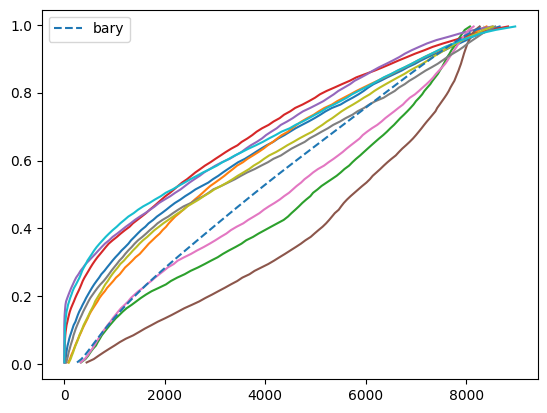

In [24]:
for i in np.random.choice(len(icdfs), 10):
    plt.plot(icdfs[i], qs)
# Compute weighted barycenter
#bary = np.average(icdfs, axis = 0)
bary = lat_weights.reshape(1, -1) @ icdfs /  lat_weights.sum()
bary = bary.ravel()
plt.plot(bary, qs, ls = "--", label = "bary")
plt.legend()
plt.show()

In [25]:
# Perform weighted PCA
# A = icdfs - bary.reshape(1, -1)
A = (icdfs - bary.reshape(1, -1))
A *= lat_weights.reshape(-1, 1) # weight according to lat weights
U, s, Vh = np.linalg.svd(A, full_matrices=False)
# Rescale U so that we can recover the full original icdfs
U /= lat_weights.reshape(-1, 1)

In [26]:
# Change sign of s
U[:,[0]] *= -1
Vh[[0],:]*= -1

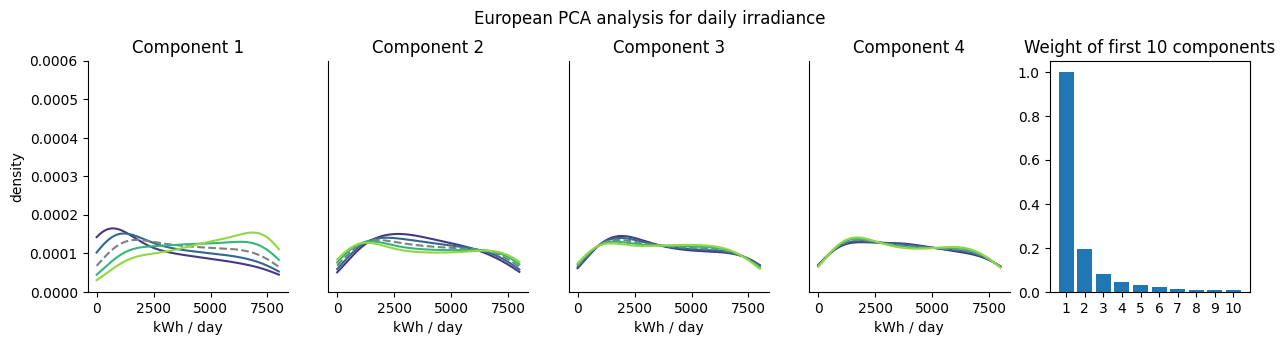

In [27]:
Ncomp = 4
density = True
x = np.linspace(0, 8000, 200)
cmap = plt.cm.viridis

fig, axs = plt.subplots(1, Ncomp+1, figsize = (15,3), dpi = 100)
for i in range(Ncomp):
    axs[i].spines[['right', 'top']].set_visible(False)

    v = Vh[i,:]
    # Change sign manually
    a = np.std(np.abs(U[:,i]*s[i]))
    for j, da in enumerate(np.linspace(-2, 2, 5)*a):
        ax = axs[i]
        z = bary + da*v
        if density: 
            kernel = gaussian_kde(z)
            y = kernel(x)
            kwargs = dict(color = cmap((da/a + 3)/6) )
            if da == 0:
                kwargs = dict(color = "gray", ls = "--")
            ax.plot(x,y,**kwargs)
            # ax.plot(z, qs,color = cmap((da/a + 3)/6), ls = "--" )
            ax.set_ylim([0,0.0006])

            axs[0].set_ylabel("density")
        else:
            ax.plot(z,qs, color = cmap((da/a + 3)/6))
            axs[0].set_ylabel("quantile")
        ax.set_xlabel("kWh / day")
        ax.set_title(f"Component {i+1}")
        if i > 0:
            ax.set_yticks([])
ax = axs[-1]

ax.bar(range(1,11), s[:10] / s[0])
ax.set_title("Weight of first 10 components")
ax.set_xticks(range(1,11))
plt.suptitle("European PCA analysis for daily irradiance", y = 1.05)
if savefig: 
    plt.savefig(figpath + "principal-components-Gday-eu.pdf", bbox_inches = "tight")

# Clustering in first 2 principal components

In [28]:
# Save first and second components in df, and downsample it
df["first"] = U[:, 0] * s[0]
df["second"] = U[:, 1] * s[1]
Ncomp = 2

df_s = utils.subsample_df(df, 0.5)
df_s

,lat,lon,tilt,G,Tamb,Tmod,Tw,E,eff,suff,lat_weights,first,second
35,28.0,-15.5,25.0,2127.471000,19.509278,24.297066,35.577182,2047.473002,0.962398,0.971341,0.882948,20875.222694,-5018.208818
156,28.5,-14.0,26.0,2270.026463,19.921572,24.654394,35.278485,2188.590247,0.964125,0.987708,0.878817,24539.943177,-6715.037365
321,35.0,25.0,28.0,2064.171928,18.840401,24.608421,40.340440,1956.049038,0.947619,0.930326,0.819152,18942.962872,-577.025673
331,35.0,25.5,31.0,2239.008876,18.979949,24.999832,39.772397,2127.926580,0.950388,0.960737,0.819152,24342.492598,-3977.600224
336,35.0,32.5,29.0,2093.249872,17.705559,23.805101,40.446050,1983.506919,0.947573,0.937170,0.819152,19922.096284,-1582.727198
...,...,...,...,...,...,...,...,...,...,...,...,...,...
264942,70.5,29.0,51.0,868.588445,-1.289001,1.114567,15.000324,874.634233,1.006960,0.519559,0.333807,-15823.463932,-3274.779673
264952,70.5,29.5,50.0,883.443220,-1.943477,0.460058,14.569790,891.404900,1.009012,0.524841,0.333807,-15473.538111,-2876.927975
264962,70.5,30.0,50.0,890.383971,-0.455793,1.923889,15.323642,896.589079,1.006969,0.528734,0.333807,-15245.043705,-2697.346550
264972,70.5,30.5,50.0,890.323288,0.947063,3.182910,15.373711,896.555444,1.007000,0.528740,0.333807,-15203.534434,-2510.415986


In [29]:
# Set random seed for reproducibility
Ncomp = 2
np.random.seed(10)
Nclusters = 3
key = ["first", "second"]
dim = len(key)
# Renormalize subsampled data
datai_s = np.array(df_s[key])
scale = np.max(datai_s) 
datai_s = datai_s / scale

# Number of KMeans trials
N_trials = 100
results_clustering = dict()
best_score = np.inf

# Try KMeans several times and keep best
for i in tqdm(range(N_trials)):
    index_init = np.random.choice(len(df_s), Nclusters, replace = False)

    _, c, _ = utils.KMeans(datai_s, K = Nclusters, Niter = 20, index_init = index_init, 
                            weights = np.array(df_s.lat_weights),  p = 2)
    D_ij = ((datai_s.reshape(-1, 1, dim) -  c.reshape(1, -1, dim))** 2).sum(-1)
    score = D_ij.min(-1).sum()
    if score < best_score:
        best_score = score
        best_c = c

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 114.01it/s]


Total representatives 151


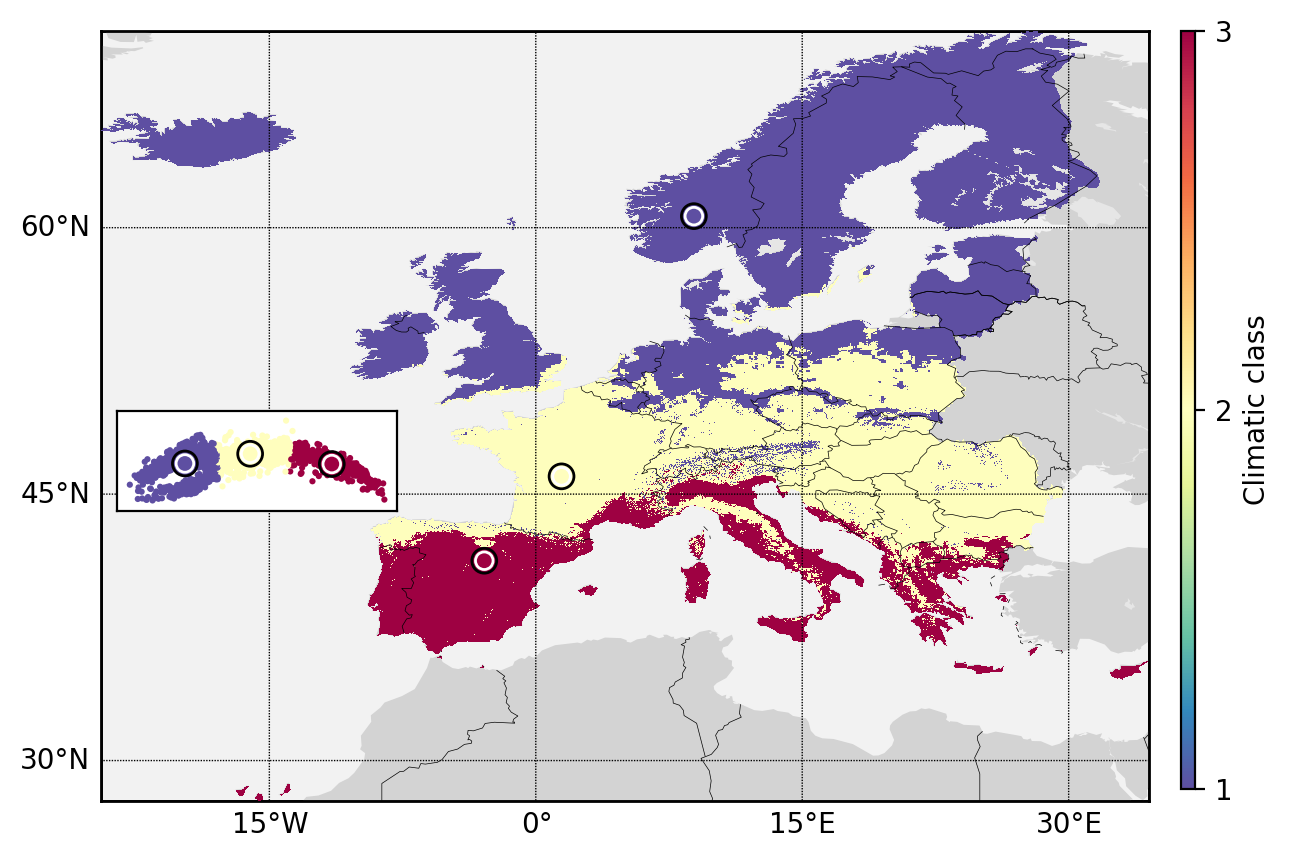

In [30]:
# Plotting part
figs = 20

savefig = True

fig, ax = plt.subplots(figsize = (7,5), ncols = 1, dpi = 200)
ax.set_rasterization_zorder(3.5)

datai = np.array(df[key])
datai /= scale

c_id_sort = np.argsort(best_c @ np.array([1, 1.5]))
c = best_c[c_id_sort]

cl = ((datai.reshape(-1, 1, dim) - c.reshape(1, -1, dim))**2).sum(-1).argmin(axis=1).reshape(-1) 
ind = utils.random_representatives(datai, c, tol=0.005)

coords = df.lat.min(), df.lat.max(), df.lon.min(), df.lon.max()
ax = utils.drawmap(ax, coords, projection = "cyl", step_grid = 15)

# cmap = "Spectral_r"
cmap = mpl.colormaps["Spectral_r"]

# cmap = "turbo"
clim = (0,1)
img,extent = utils.rasterize(df.lat, df.lon, cl+1)
ims = plt.imshow(img, origin = "lower", cmap = cmap, extent = extent,
        interpolation = "nearest", zorder = 3, clim = (1, Nclusters))

# Show centroids on map

ax.scatter(df.lon[ind], df.lat[ind], c = np.arange(Nclusters), marker = "o", edgecolor = "k", linewidth = 1, cmap = cmap, s = 80, clim = (0, Nclusters-1), zorder = 100)
ax.scatter(df.lon[ind], df.lat[ind], c = np.arange(Nclusters), marker = "o", edgecolor = "w", linewidth = 1, cmap = cmap, s = 40, clim = (0, Nclusters-1), zorder = 200)

subax = fig.add_axes([0.15,0.4,0.2, 0.1])
subax.axis("equal")
subax.set_xticks([])
subax.set_yticks([])

cl_s = ((datai_s.reshape(-1, 1, dim) - c.reshape(1, -1, dim))**2).sum(-1).argmin(axis=1).reshape(-1) 

subax.scatter(datai_s[:,0], datai_s[:,1], c = cl_s, s = 5, cmap = cmap, edgecolor = "none")

subax.scatter(c[:,0], c[:,1], c = np.arange(Nclusters), marker = "o", edgecolor = "k", linewidth = 1, cmap = cmap, s = 80, clim = (0, Nclusters-1))
subax.scatter(c[:,0], c[:,1], c = np.arange(Nclusters), marker = "o", edgecolor = "w", linewidth = 1, cmap = cmap, s = 40, clim = (0, Nclusters-1))
# subax.legend(markerscale = 2, loc = (0,1.1), title = "Cluster id")

subax.set_rasterization_zorder(1.5)

# Classification bar
clax = fig.add_axes((0.91,0.122, 0.01, 0.758))
plt.colorbar(ims, cax = clax)
clax.set_ylabel("Climatic class")
clax.set_yticks(np.arange(1,Nclusters+1))


plt.show()


